In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [3]:
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
data = data.fillna(method="ffill")

In [5]:
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 9216
Unique tags in corpus: 17


In [7]:
words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())

In [8]:


print("Unique tags are:", tags)


Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [9]:
num_words = len(words)
num_tags = len(tags)

In [10]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [12]:
len(sentences)

3300

In [13]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [14]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [15]:
word2idx

{'Thousands': 1,
 'of': 2,
 'demonstrators': 3,
 'have': 4,
 'marched': 5,
 'through': 6,
 'London': 7,
 'to': 8,
 'protest': 9,
 'the': 10,
 'war': 11,
 'in': 12,
 'Iraq': 13,
 'and': 14,
 'demand': 15,
 'withdrawal': 16,
 'British': 17,
 'troops': 18,
 'from': 19,
 'that': 20,
 'country': 21,
 '.': 22,
 'Families': 23,
 'soldiers': 24,
 'killed': 25,
 'conflict': 26,
 'joined': 27,
 'protesters': 28,
 'who': 29,
 'carried': 30,
 'banners': 31,
 'with': 32,
 'such': 33,
 'slogans': 34,
 'as': 35,
 '"': 36,
 'Bush': 37,
 'Number': 38,
 'One': 39,
 'Terrorist': 40,
 'Stop': 41,
 'Bombings': 42,
 'They': 43,
 'Houses': 44,
 'Parliament': 45,
 'a': 46,
 'rally': 47,
 'Hyde': 48,
 'Park': 49,
 'Police': 50,
 'put': 51,
 'number': 52,
 'marchers': 53,
 'at': 54,
 '10,000': 55,
 'while': 56,
 'organizers': 57,
 'claimed': 58,
 'it': 59,
 'was': 60,
 '1,00,000': 61,
 'The': 62,
 'comes': 63,
 'on': 64,
 'eve': 65,
 'annual': 66,
 'conference': 67,
 'Britain': 68,
 "'s": 69,
 'ruling': 70,
 'L

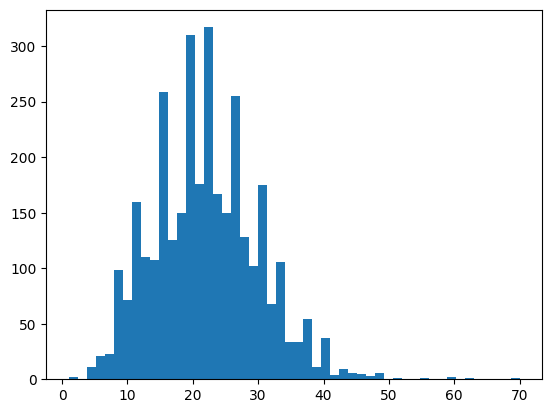

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [17]:
X1 = [[word2idx[w[0]] for w in s] for s in sentences]

In [18]:
type(X1[0])

list

In [19]:
X1[0]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 10,
 16,
 2,
 17,
 18,
 19,
 20,
 21,
 22]

In [20]:
max_len = 50

In [21]:
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)

In [22]:
X[0]

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   10,   16,    2,   17,   18,   19,   20,
         21,   22, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216,
       9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216,
       9216, 9216, 9216, 9216, 9216, 9216], dtype=int32)

In [23]:

y1 = [[tag2idx[w[2]] for w in s] for s in sentences]

In [24]:
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

In [26]:


X_train[0]





array([ 596,  173, 4846,   79,   46,  621,    2,  488,   14,  274, 2020,
          8, 1690, 6357,   22, 9216, 9216, 9216, 9216, 9216, 9216, 9216,
       9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216,
       9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216, 9216,
       9216, 9216, 9216, 9216, 9216, 9216], dtype=int32)

In [27]:
y_train[0]

array([0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [28]:
input_word = layers.Input(shape=(max_len,))
# Write your code here
embedding_layer = layers.Embedding(input_dim = num_words,
                                   output_dim = 50,
                                   input_length = max_len)(input_word)
dropout_layer = layers.SpatialDropout1D(0.1)(embedding_layer)
bidirectional_lstm = layers.Bidirectional(layers.LSTM(
    units=100, return_sequences=True,recurrent_dropout=0.1))(dropout_layer)
output = layers.TimeDistributed(
    layers.Dense(num_tags, activation="softmax"))(bidirectional_lstm)
model = Model(input_word, output)

In [29]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            460850    
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [30]:
# Write your code here
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [31]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=3,
)

Epoch 1/3
83/83 [==============================] - 26s 241ms/step - loss: 0.6933 - accuracy: 0.9189 - val_loss: 0.3374 - val_accuracy: 0.9332
Epoch 2/3
83/83 [==============================] - 18s 220ms/step - loss: 0.3079 - accuracy: 0.9345 - val_loss: 0.2930 - val_accuracy: 0.9332
Epoch 3/3
83/83 [==============================] - 20s 238ms/step - loss: 0.2382 - accuracy: 0.9359 - val_loss: 0.2158 - val_accuracy: 0.9391


In [32]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693326,0.918856,0.337419,0.933152
1,0.307917,0.934455,0.293045,0.933152
2,0.238183,0.935856,0.215751,0.939061


<Axes: >

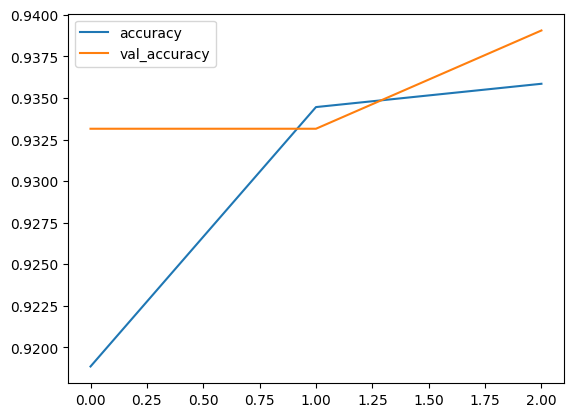

In [33]:


metrics[['accuracy','val_accuracy']].plot()





<Axes: >

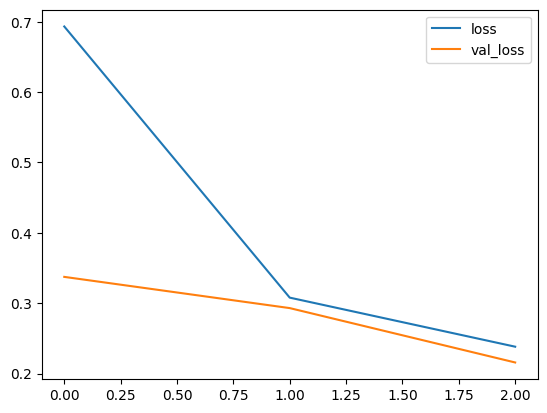

In [34]:
metrics[['loss','val_loss']].plot()




In [35]:
i = 20
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 496ms/step
Word           True 	 Pred

------------------------------
Burma          B-geo	O
's             O	O
detained       O	O
democracy      O	O
leader         O	O
Aung           B-geo	O
San            I-geo	O
Suu            I-geo	O
Kyi            I-geo	O
has            O	O
appealed       O	O
to             O	O
the            O	O
ruling         O	O
military       O	O
against        O	O
her            O	O
home           O	O
confinement    O	O
.              O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards        